<a href="https://colab.research.google.com/github/chrismartel/ECSE415-Project-G7/blob/main/classification/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Download Vehicle Dataset

In [1]:
!wget -O output https://mcgill-my.sharepoint.com/:u:/g/personal/raghav_mehta_mail_mcgill_ca/EVEvhY9_jyVEk2uSZ8wZhFYBQ58C57I7ZB55jBocKwB5Jg?download=1
!mv output dataset.zip
!unzip dataset.zip
!rm dataset.zip

--2022-03-22 17:47:09--  https://mcgill-my.sharepoint.com/:u:/g/personal/raghav_mehta_mail_mcgill_ca/EVEvhY9_jyVEk2uSZ8wZhFYBQ58C57I7ZB55jBocKwB5Jg?download=1
Resolving mcgill-my.sharepoint.com (mcgill-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to mcgill-my.sharepoint.com (mcgill-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/raghav_mehta_mail_mcgill_ca/Documents/dataset.zip [following]
--2022-03-22 17:47:11--  https://mcgill-my.sharepoint.com/personal/raghav_mehta_mail_mcgill_ca/Documents/dataset.zip
Reusing existing connection to mcgill-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 826880986 (789M) [application/x-zip-compressed]
Saving to: ‘output’

output              100%[===================>] 788.57M  86.0MB/s    in 10s     

2022-03-22 17:47:21 (77.9 MB/s) - ‘output’ saved [826880986/826880986]

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2 as cv

def parse(filepath):
  '''
      Parse gt.txt with format
        <frame>, <id>, <type>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>, <y>, <z>, <ry>
      Return dict as:
        <type> = "Car", "Van", "Truck", "Pedastrian", "Person_sitting", "Cyclist", "Tram", "Misc", "DontCare"
        key: frame
        value: list - <id>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <is_vehicle>
      Feel free to edit your structure as needed!
  '''

  used_type = ["Car", "Van", "Truck", "Tram"]

  lines = open(filepath, "r").readlines()                                 
  bbox = {}

       #  <frame>, <id>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>,   <y>,   <z>,   <ry>
  mask = [False,   True,  False,       False,      False,   True,      True,     True,       True,        False,  False,  False,  False, False, False, False]
  
  for line in lines:
    l = line.strip().split(' ') #convert line to list
    typ = l.pop(2)  # get type of bbox 
    line = np.asarray(l).astype(np.float32) # convert into array 
    frame, line = int(line[0]), line[mask] # get frame number and mask the line   
    if frame not in bbox.keys():
      bbox[frame] = []   
    if typ in used_type:
        bbox[frame].append(line)
  return bbox

def add_bbox(img, bbox, color=(255, 0, 0), thickness=2):
  ''' 
    annotate an image with bounding boxes:
    supports single bbox or list of bboxs
  '''

  annotated = np.copy(img)
  if bbox: 
    if isinstance(bbox[0], np.ndarray) or isinstance(bbox[0], list):
        for (_,x1,y1,x2,y2) in bbox:
            cv.rectangle(annotated, (x1, y1), (x2, y2), color , thickness)
    else:
        _,x1,y1,x2,y2 = bbox
        cv.rectangle(annotated, (x1, y1), (x2, y2), color , thickness)
  
  return annotated

In [4]:
"""
Check if two rectangle intersect in a x-y coordinate system.
r1: tuple (x1,y1,x2,y2) coordinates of rectangle 1
r2: tuple (x1,y1,x2,y2) coordinates of rectangle 2
return True if r1 and r2 interesect False otherwise.
"""
def intersection(r1, r2):
  if r1[0] >= r2[2] or r1[2] <= r2[0] or r1[1] >= r2[3] or r1[3] <= r2[1]:
    return False
  else:
    return True


##**Build Dataset**


###Positive Dataset

Use provided bounding boxes from train dataset

###Negative Dataset

Use different objects from random patches in train dataset

In [141]:
from matplotlib.cbook import maxdict
import os
import cv2 as cv
from random import randint

number_of_sequences = 4

sequences = list()

number_of_negative_samples_per_frame = 20

minimum_bbox_h, maximum_bbox_h = 40, 150
minimum_bbox_w, maximum_bbox_w = 50, 200

max_diff_width_height = 20

number_of_samples = 0
for image_sequence in range(number_of_sequences):

  samples = list()

  bboxes = parse('dataset/000{image_sequence}.txt'.format(image_sequence=image_sequence))
  for frame_id, frame_bboxes in bboxes.items():

    img = cv.imread('dataset/000{image_sequence}/{frame_id:06d}.png'.format(image_sequence=image_sequence, frame_id=frame_id))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    for sample in range(number_of_negative_samples_per_frame):

        while(True):
          random_y1 = randint(0,img.shape[0])
          random_y2 = randint(random_y1,img.shape[0])

          random_x1 = randint(0,img.shape[1])
          random_x2 = randint(random_x1,img.shape[1])

          # validate dimensions
          if random_y2 - random_y1 < minimum_bbox_h or random_y2 - random_y1 > maximum_bbox_h:
            continue
          if random_x2 - random_x1 < minimum_bbox_h or random_x2 - random_x1 > maximum_bbox_w:
            continue

          if abs((random_x2 - random_x1) - (random_y2 - random_y1)) > max_diff_width_height:
            continue

          random_bbox = (random_x1, random_y1, random_x2, random_y2)

          # validate no-intersection with vehicles
          valid = True
          for (id, x1,y1,x2,y2) in frame_bboxes:
            if intersection((x1,y1,x2,y2), random_bbox):
              valid = False
              break

          if valid:
            break

        # extract patch
        random_bbox_img = img[random_y1:random_y2,random_x1:random_x2]
        samples.append((random_bbox_img,0))

    for bbox in frame_bboxes:
      id, x1, y1, x2, y2 = bbox.astype('int32')
      
      bbox_img = img[y1:y2,x1:x2]
      samples.append((bbox_img,1))

  sequences.append(samples)
  number_of_samples += len(samples)

####Dataset Statistics

- Aspect Ratio
- Image Sizes

In [142]:
import numpy as np

# Number of samples
number_of_samples = 0
for seq in sequences:
  number_of_samples += len(seq)

# Class distribution
class_count = np.zeros(2)

# compute statistics on full image dataset
aspect_ratios = np.zeros(number_of_samples)
min_aspect_ratio, max_aspect_ratio = np.iinfo(np.int32).max, 0

widths = np.zeros(number_of_samples)
min_width, max_width = np.iinfo(np.int32).max, 0

heights = np.zeros(number_of_samples)
min_height, max_height = np.iinfo(np.int32).max, 0

# min-max values used for normalization
global_min = np.iinfo('int32').max
global_max = 0

for seq in sequences:
  for i, (sample,label) in enumerate(seq):
    widths[i] = sample.shape[1]
    min_width = widths[i] if widths[i] < min_width else min_width
    max_width = widths[i] if widths[i] > max_width else max_width

    heights[i] = sample.shape[0]
    min_height = heights[i] if heights[i] < min_height else min_height
    max_height = widths[i] if widths[i] > max_height else max_height

    aspect_ratios[i] = heights[i] / float(widths[i])
    min_aspect_ratio = aspect_ratios[i] if aspect_ratios[i] < min_aspect_ratio else min_aspect_ratio
    max_aspect_ratio = aspect_ratios[i] if aspect_ratios[i] > max_aspect_ratio else max_aspect_ratio

    cur_min, cur_max = np.min(sample), np.max(sample)
    global_min =  cur_min if cur_min < global_min else global_min
    global_max =  cur_max if cur_max > global_max else global_max

    class_count[label] += 1

aspect_ratio_interval = int(max_aspect_ratio - min_aspect_ratio)
width_interval = int(max_width - min_width)
height_interval = int(max_height - min_height)

aspect_ratio_banks = range(int(min_aspect_ratio), int(max_aspect_ratio), aspect_ratio_interval)
width_banks = range(int(min_width), int(max_width), width_interval)
height_banks = range(int(min_height), int(max_height), height_interval)

# Todo display number of instances in each range

####Class Distribution

Display number of vehicle and non-vehicle images in dataset

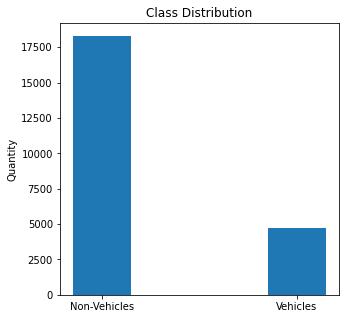

In [143]:
plt.figure(figsize=(5,5))
plt.bar(['Non-Vehicles','Vehicles'],class_count, width=0.3)
plt.ylabel('Quantity')
plt.title("Class Distribution")
plt.show()

##**Image Preprocessing**



*   Resize Images
*   Normalize Images
*   Extract HoG Features






In [150]:
from skimage.transform import resize
from skimage.feature import hog
import numpy as np

W = 128
H = 80

# HoG parameters

# Input image size
W = 128
H = 80
orientations = 9 # number of orientation bins
pixels_per_cell = (8,8) # number of pixels per cell
cells_per_block = (2,2) # number of cells per block

# get hog feature vector length
number_hog_features = len(hog(np.zeros((H,W)), orientations=orientations, pixels_per_cell = pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True))

hog_dataset = dict()

# Preprocessing
for i, seq in enumerate(sequences):
  hog_samples = np.zeros((len(seq), number_hog_features))
  labels = np.zeros(len(seq))
  for j, (sample, label) in enumerate(seq):
    # resize image
    resized = resize(sample, (H,W))

    # min-max normalization
    normalized = (resized - global_min) / (global_max - global_min)

    # compute hog features
    labels[j] = label
    hog_samples[j] = hog(normalized, orientations=orientations, pixels_per_cell = pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True, multichannel=True)
  hog_dataset[i] = (hog_samples, labels)

###**3-Fold Cross-Validation**

For each validation, choose an image sequence to be the validation set

In [155]:
for i in range(number_of_sequences):
  print(len(hog_dataset[i][1]))

3615
11838
4278
3268


In [112]:
K = 3

# shuffle data
n = x.shape[0]
inds = list(range(n))
shuffle(inds)

step = int(n/K)

# predictions for each fold
accuracies = np.zeros(K)

for i in range(K):
  if i == 0:
    x_val, y_val = hog_dataset[:step], y[:step]
    x_train, y_train = x[step:], y[step:]
  elif i == K-1:
    x_val, y_val = x[-step:], y[-step:]
    x_train, y_train = x[:i*step], y[:i*step]
  else:
    x_val, y_val = x[i*step:i*step+step], y[i*step:i*step+step]
    x_train, y_train = np.concatenate((x[:i*step], x[i*step+step:]), axis=0), np.concatenate((y[:i*step], y[i*step+step:]), axis=0)


  



